## 1. Import Required Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
import re
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

## 2. Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
train_data = pd.read_csv('/content/drive/MyDrive/sentiment_dataset/phm_train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/sentiment_dataset/phm_test.csv')

print("Training Data Shape:", train_data.shape)
print("Test Data Shape:", test_data.shape)
print("\nFirst few rows of training data:")
print(train_data.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training Data Shape: (9991, 3)
Test Data Shape: (3331, 3)

First few rows of training data:
       tweet_id  label                                              tweet
0  6.430000e+17      0  user_mention all i can tell you is i have had ...
1  6.440000e+17      0  my doctor told me stop he gave me sum pop i mi...
2  8.150000e+17      1  i take tylenol and i wake up in the middle of ...
3  6.820000e+17      0  i got xans in an advil bottle i dont take them...
4  6.440000e+17      1  mom says i need to stop eating so much bc ive ...


## 3. Exploratory Data Analysis

In [ ]:
print("Missing values in training data:")
print(train_data.isnull().sum())
print("\nMissing values in test data:")
print(test_data.isnull().sum())

print("\nClass distribution in training data:")
print(train_data['label'].value_counts())
print("\nClass distribution (percentage):")
print(train_data['label'].value_counts(normalize=True) * 100)

Missing values in training data:
tweet_id    0
label       0
tweet       0
dtype: int64

Missing values in test data:
tweet_id    0
label       0
tweet       0
dtype: int64

Class distribution in training data:
label
0    7091
1    2900
Name: count, dtype: int64

Class distribution (percentage):
label
0    70.973876
1    29.026124
Name: proportion, dtype: float64


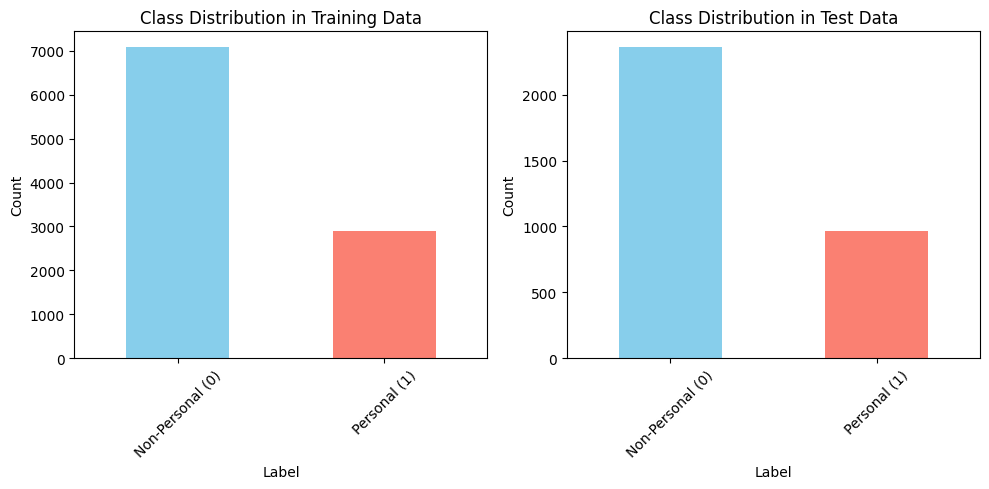

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
train_data['label'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution in Training Data')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Personal (0)', 'Personal (1)'], rotation=45)

plt.subplot(1, 2, 2)
test_data['label'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution in Test Data')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Personal (0)', 'Personal (1)'], rotation=45)

plt.tight_layout()
plt.show()

## 4. Data Preprocessing

In [ ]:
import nltk
nltk.download('stopwords')
english_stops = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def preprocess_text(text):
    """
    Preprocess tweet text:
    - Convert to lowercase
    - Remove URLs, mentions, hashtags
    - Remove special characters and numbers
    - Remove extra whitespace
    - Remove stopwords (optional - can be commented out for better performance)
    """

    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+|#\w+', '', text)
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [7]:
# Apply preprocessing
print("Preprocessing tweets...")
train_data['cleaned_tweet'] = train_data['tweet'].apply(preprocess_text)
test_data['cleaned_tweet'] = test_data['tweet'].apply(preprocess_text)

print("\nExample of original vs cleaned tweets:")
for i in range(3):
    print(f"\nOriginal: {train_data['tweet'].iloc[i]}")
    print(f"Cleaned:  {train_data['cleaned_tweet'].iloc[i]}")

Preprocessing tweets...

Example of original vs cleaned tweets:

Original: user_mention all i can tell you is i have had few relapses on it it is not a cure i hear if you dont test for the jc virus tysabri is good
Cleaned:  user mention all i can tell you is i have had few relapses on it it is not a cure i hear if you dont test for the jc virus tysabri is good

Original: my doctor told me stop he gave me sum pop i mix it up w some adderall and wait to get to the top i mix it up w some alcohol pour
Cleaned:  my doctor told me stop he gave me sum pop i mix it up w some adderall and wait to get to the top i mix it up w some alcohol pour

Original: i take tylenol and i wake up in the middle of the night to put my ice pack on my belly and back for a couple of seconds so i can sleep
Cleaned:  i take tylenol and i wake up in the middle of the night to put my ice pack on my belly and back for a couple of seconds so i can sleep


In [ ]:
X_train = train_data['cleaned_tweet'].values
y_train = train_data['label'].values
X_test = test_data['cleaned_tweet'].values
y_test = test_data['label'].values

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Training samples: 9991
Test samples: 3331


## 5. Tokenization and Padding

In [ ]:
def get_max_length(texts):
    lengths = [len(text.split()) for text in texts]
    mean_length = np.mean(lengths)
    std_length = np.std(lengths)
    max_length = int(np.ceil(mean_length + std_length))
    return max_length

max_length = get_max_length(X_train)
print(f"Maximum sequence length: {max_length}")

Maximum sequence length: 23


In [ ]:
MAX_WORDS = 10000

tokenizer = Tokenizer(num_words=MAX_WORDS, lower=True, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

print(f"Vocabulary size: {len(tokenizer.word_index)}")
print(f"X_train shape: {X_train_pad.shape}")
print(f"X_test shape: {X_test_pad.shape}")

Vocabulary size: 12792
X_train shape: (9991, 23)
X_test shape: (3331, 23)


## 6. Build Vanilla LSTM Model

In [ ]:
EMBEDDING_DIM = 128
LSTM_UNITS = 64
DROPOUT_RATE = 0.4
EPOCHS = 20
BATCH_SIZE = 64

In [ ]:
model = Sequential([
    Embedding(input_dim=MAX_WORDS, 
              output_dim=EMBEDDING_DIM, 
              input_length=max_length,
              name='embedding_layer'),
    
    SpatialDropout1D(DROPOUT_RATE, name='spatial_dropout'),
    
    LSTM(LSTM_UNITS, 
         dropout=DROPOUT_RATE,
         recurrent_dropout=0.3,
         name='lstm_layer'),
    
    Dense(32, activation='relu', name='dense_1'),
    Dropout(DROPOUT_RATE, name='dropout'),
    
    Dense(1, activation='sigmoid', name='output_layer')
], name='Vanilla_LSTM')

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

Model: "Vanilla_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout                 │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer (LSTM)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


## 7. Model Training with Callbacks

In [ ]:
from sklearn.model_selection import train_test_split
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_pad, y_train, test_size=0.15, random_state=42, stratify=y_train
)

print(f"Training samples: {len(X_train_final)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test_pad)}")

Training samples: 8492
Validation samples: 1499
Test samples: 3331


In [14]:
# Define callbacks
checkpoint = ModelCheckpoint(
    'best_lstm_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=0.00001,
    verbose=1
)

In [ ]:
print("Training Vanilla LSTM model...")
history = model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[checkpoint, early_stopping, reduce_lr],
    verbose=1
)

Training Vanilla LSTM model...
Epoch 1/20


133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.6946 - loss: 0.6151
Epoch 1: val_accuracy improved from -inf to 0.82455, saving model to best_lstm_model.h5


133/133 ━━━━━━━━━━━━━━━━━━━━ 17s 72ms/step - accuracy: 0.6948 - loss: 0.6147 - val_accuracy: 0.8245 - val_loss: 0.3996 - learning_rate: 0.0010
Epoch 2/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8229 - loss: 0.4223
Epoch 2: val_accuracy improved from 0.82455 to 0.83856, saving model to best_lstm_model.h5


133/133 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - accuracy: 0.8230 - loss: 0.4221 - val_accuracy: 0.8386 - val_loss: 0.3644 - learning_rate: 0.0010
Epoch 3/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8604 - loss: 0.3569
Epoch 3: val_accuracy improved from 0.83856 to 0.84390, saving model to best_lstm_model.h5


133/133 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.8604 - loss: 0.3567 - val_accuracy: 0.8439 - val_loss: 0.3675 - learning_rate: 0.0010
Epoch 4/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8840 - loss: 0.3037
Epoch 4: val_accuracy did not improve from 0.84390
133/133 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.8840 - loss: 0.3036 - val_accuracy: 0.8392 - val_loss: 0.3798 - learning_rate: 0.0010
Epoch 5/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9047 - loss: 0.2605
Epoch 5: val_accuracy did not improve from 0.84390

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
133/133 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.9047 - loss: 0.2605 - val_accuracy: 0.8432 - val_loss: 0.3811 - learning_rate: 0.0010
Epoch 6/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9210 - loss: 0.2218
Epoch 6: val_accuracy did not improve from 0.84390
133/133 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.9210 - loss: 0.2218 - val

## 8. Model Evaluation

In [ ]:
best_model = load_model('best_lstm_model.h5')

test_loss, test_accuracy = best_model.evaluate(X_test_pad, y_test, verbose=1)
print(f"Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8103 - loss: 0.4312
Training Loss: 0.2049
Training Accuracy: 0.9280
Test Loss: 0.3879
Test Accuracy: 0.8343


In [ ]:
y_pred_proba = best_model.predict(X_test_pad)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Personal (0)', 'Personal (1)']))

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC Score: {roc_auc:.4f}")

105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step

Classification Report:
                  precision    recall  f1-score   support

Non-Personal (0)       0.88      0.88      0.88      2364
    Personal (1)       0.71      0.72      0.71       967

        accuracy                           0.83      3331
       macro avg       0.80      0.80      0.80      3331
    weighted avg       0.83      0.83      0.83      3331


ROC-AUC Score: 0.8982


## 9. Training History Visualization

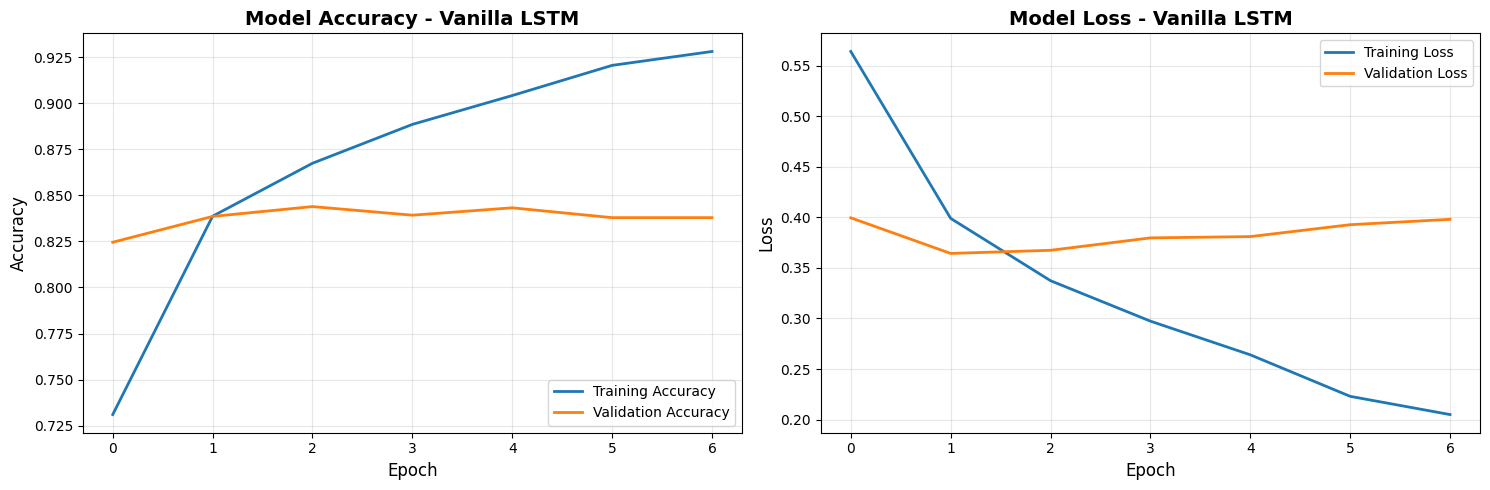

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy - Vanilla LSTM', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_title('Model Loss - Vanilla LSTM', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('vanilla_lstm_training_history.png', dpi=300, bbox_inches='tight')
plt.show()